In [1]:
#! pip install biopython

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Retrieve Promoter Sequences from Ensembl
import pandas as pd
from tqdm import tqdm
import requests

# Length of promoter to retrieve
Len_Pro = 600

# Load both gene expression lists from CSV files with CPM from pseudo-bulk analysis of scRNAseq
# GeneID, Ensembl_ID, CPM_TUMOR, CPM_SPLEEN
gene_file = '/content/drive/MyDrive/ICE-T_ProDat/Gene_CPM.csv'

# Load the gene expression dataframes
genes_df = pd.read_csv(gene_file)
print(f"Number of genes in the gene expression dataframe: {len(genes_df)}")

# Filter the entries without Ensembl IDs or MT genes
genes_df = genes_df[
    (genes_df['Ensembl_ID'].notna()) &
    (genes_df['Ensembl_ID'] != '') &
    (~genes_df['GeneID'].astype(str).str.startswith('MT-'))
].copy()

# Check ID retrieval
print(genes_df.head())

# Fetch gene information from the Ensembl REST API.
def get_gene_info(ensembl_id):
    server = "http://rest.ensembl.org"
    ext = f"/lookup/id/{ensembl_id}?expand=1"  # Endpoint to get gene info with expanded transcripts
    headers = {"Content-Type": "application/json"}
    # Send a GET request to the Ensembl REST API
    r = requests.get(server + ext, headers=headers)
    # Check if the request was successful
    if not r.ok:
        r.raise_for_status()
    return r.json() # A dictionary containing gene information, including transcripts.

# Select the longest transcript from the gene information.
def get_longest_transcript(gene_info):
    transcripts = gene_info.get('Transcript', [])
    # Check if there are any transcripts available
    if not transcripts:
        print("No transcripts found for this gene")
        return None
    # Sort the transcripts by their length (end - start) in descending order
    transcripts.sort(key=lambda t: t['end'] - t['start'], reverse=True)
    # Return the first transcript from the sorted list (the longest one)
    return transcripts[0]

# Determine the Transcription Start Site (TSS) of the transcript.
def get_TSS(transcript):
    strand = transcript['strand']
    # For forward strand, TSS is at the start position
    if strand == 1:
        TSS = transcript['start']
    # For reverse strand, TSS is at the end position
    elif strand == -1:
        TSS = transcript['end']
    else:
        raise ValueError("Invalid strand value")
    return TSS #The coordinate of the TSS.

# Calculate the promoter region coordinates based on the TSS and strand.
def get_promoter_region(TSS, strand):
    # For forward strand, promoter is upstream (lower coordinates)
    if strand == 1:
        promoter_start = TSS - Len_Pro
        promoter_end = TSS - 1
    # For reverse strand, promoter is upstream (higher coordinates)
    elif strand == -1:
        promoter_start = TSS + 1
        promoter_end = TSS + Len_Pro
    else:
        raise ValueError("Invalid strand value")
    # Ensure promoter_start is not less than 1
    promoter_start = max(promoter_start, 1)
    return promoter_start, promoter_end #A tuple containing promoter_start and promoter_end coordinates.

# Retrieve the DNA sequence for the specified region using the Ensembl REST API.
def get_sequence(species, seq_region_name, start, end, strand):
    server = "http://rest.ensembl.org"
    # Define the region in Ensembl format (e.g., "X:1000000..1000500:1")
    region = f"{seq_region_name}:{start}..{end}:{strand}"
    ext = f"/sequence/region/{species}/{region}"
    headers = {"Content-Type": "text/plain"}
    # Send a GET request to retrieve the sequence
    try:
        r = requests.get(server + ext, headers=headers)
        # Check if the request was successful
        r.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        # Return the sequence as text
        return r.text
    except requests.exceptions.HTTPError as err:
        if err.response.status_code == 400:
            print(f"Error: Bad Request for {seq_region_name}:{start}..{end}:{strand}")
            # Handle the error (e.g., skip this gene, return None, etc.)
            return None  # Or choose another way to handle it
        else:
            raise  # Re-raise other HTTP errors

# Retrieve the promoter sequence (-Len_Pro bp upstream of the TSS) for the longest transcript of a gene.
def get_promoter_sequence(ensembl_id):
    # Fetch gene information
    gene_info = get_gene_info(ensembl_id)
    # Get the longest transcript
    longest_transcript = get_longest_transcript(gene_info)
    if not longest_transcript:
        print("Longest transcript not found")
        return None
    # Extract necessary information from the transcript
    strand = longest_transcript['strand']
    seq_region_name = longest_transcript['seq_region_name']
    TSS = get_TSS(longest_transcript)
    # Calculate promoter region coordinates
    promoter_start, promoter_end = get_promoter_region(TSS, strand)
    # Retrieve the promoter sequence
    sequence = get_sequence('human', seq_region_name, promoter_start, promoter_end, strand)
    # Get the chromosome information
    chromosome = seq_region_name
    return sequence, chromosome

# Retrieve and trim promoter sequences for both gene lists, saving every 500 entries
promoter_sequences = []
chromosomes = []
for i, ensembl_id in enumerate(tqdm(genes_df['Ensembl_ID'], desc="Retrieving Promoter Sequences for Gene List")):
    # Retrieve the promoter sequence and chromosome from the function
    sequence, chromosome = get_promoter_sequence(ensembl_id)
    # Append the sequence and chromosome separately
    chromosomes.append(chromosome)
    promoter_sequences.append(sequence)
    # Save every 500 entries
    if (i + 1) % 500 == 0:
        # Copy the current processed data
        temp_df = genes_df.iloc[:i+1].copy()
        # Assign promoter sequences and chromosome columns
        temp_df['ProSeq'] = promoter_sequences
        temp_df['Chr'] = chromosomes
        # Save to CSV
        temp_df.to_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_temp.csv', index=False)
        print(f"Saved {i + 1} entries to ProSeq_temp.csv")

# Save the final dataframe
genes_df = genes_df.copy()
genes_df['ProSeq'] = promoter_sequences
genes_df['Chr'] = chromosomes
genes_df.to_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_raw.csv', index=False)
print("All entries saved to ProSeq_raw.csv")


In [ ]:
#@title Data processing
# Install necessary packages
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go

# Load data
data = pd.read_csv("/content/drive/MyDrive/ICE-T_ProDat/ProSeq_raw.csv")

# Set your preferred length for the promoter sequence
Len_Pro = 300  # Modify this value as needed

# Process the ProSeq column
def process_promoter(sequence):
    if pd.isna(sequence) or sequence == "":
        return None  # Return None for empty sequences
    elif len(sequence) > Len_Pro:
        return sequence[-Len_Pro:]  # Trim to Len_Pro
    else:
        return sequence.ljust(Len_Pro, 'N')  # Pad with 'N' if shorter than Len_Pro

# Process the Chr column for Patches and Haplotytpes
def process_chr(chr_value):
    if 'PATCH' in chr_value:
        return 'PATCH'
    else:
        # Regular expression to match 'HSCHR' followed by 1-23, X, or Y
        match = re.match(r'^HSCHR(1[0-9]|2[0-3]|[1-9]|X|Y)', chr_value)
        if match:
            return match.group(1)
        else:
            return chr_value  # Keep the original value if no match

# Apply the processing function and drop rows with empty sequences
data['Promoter'] = data['ProSeq'].apply(process_promoter)
empty_genes = data[data['Promoter'].isnull()]['GeneID']
data = data.dropna(subset=['Promoter'])

# Apply the processing function to the 'Chr' column
data['Chr'] = data['Chr'].apply(process_chr)

# Print names of genes with empty ProSeq sequences
if not empty_genes.empty:
    print("Genes with empty Promoter sequences:")
    print(empty_genes.tolist())

# Transform CPM_TUMOR and CPM_SPLEEN to log2 format. ALL added 0.5 to avoid log2(0).
data['log2_TUMOR'] = np.log2(data['CPM_TUMOR']+0.5)
data['log2_SPLEEN'] = np.log2(data['CPM_SPLEEN']+0.5)

# Calculate log2 fold change (Log2FC)
data['log2FC'] = data['log2_TUMOR'] - data['log2_SPLEEN']

# Rename and reorder columns as per requirements
processed_data = data.rename(columns={'Chr': 'Chromosome'})
processed_data = processed_data[['GeneID', 'Chromosome', 'log2_TUMOR', 'log2_SPLEEN', 'log2FC', 'Promoter']]

# Export processed data to CSV
processed_data.to_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_processed.csv', index=False)

# Interactive figures and HTML report generation

# Total number of DNA sequences
total_sequences = len(processed_data)

# Length of processed sequences
processed_sequence_lengths = processed_data['Promoter'].apply(len)

# Count genes with log2FC > log2(2) and < -log2(2)
log2_threshold = np.log2(2)
num_greater = len(processed_data[processed_data['log2FC'] > log2_threshold])
num_less = len(processed_data[processed_data['log2FC'] < -log2_threshold])

# Define the desired chromosome order
desired_order = [str(i) for i in range(1, 24)] + ['X', 'Y', 'PATCH']

# Convert 'Chromosome' column in processed_data to categorical with the desired order
processed_data['Chromosome'] = pd.Categorical(
    processed_data['Chromosome'],
    categories=desired_order,
    ordered=True
)

# Drop any rows with chromosomes not in desired_order (optional)
processed_data = processed_data.dropna(subset=['Chromosome'])

# Re-calculate the chromosome percentage table (if necessary)
chromosome_counts = processed_data['Chromosome'].value_counts(normalize=True) * 100
chromosome_percentage_table = pd.DataFrame({
    'Chromosome': chromosome_counts.index,
    'Percentage': chromosome_counts.values
})

# Ensure the chromosome percentage table is sorted
chromosome_percentage_table = chromosome_percentage_table.sort_values('Chromosome')

# Filter genes with significant log2FC
significant_genes = processed_data[(processed_data['log2FC'] > log2_threshold) | (processed_data['log2FC'] < -log2_threshold)]

# Calculate the chromosome distribution percentage for significant genes
significant_chromosome_counts = significant_genes['Chromosome'].value_counts(normalize=True) * 100
significant_chromosome_percentage_table = pd.DataFrame({
    'Chromosome': significant_chromosome_counts.index,
    'Percentage': significant_chromosome_counts.values
})

# Ensure the chromosome percentage table is sorted by the desired order
significant_chromosome_percentage_table['Chromosome'] = pd.Categorical(
    significant_chromosome_percentage_table['Chromosome'],
    categories=desired_order,
    ordered=True
)
significant_chromosome_percentage_table = significant_chromosome_percentage_table.sort_values('Chromosome')

# Interactive histograms and plots
fig1 = px.histogram(processed_data, x='log2_TUMOR', title='Distribution of log2_TUMOR')
fig2 = px.histogram(processed_data, x='log2_SPLEEN', title='Distribution of log2_SPLEEN')
fig3 = px.histogram(processed_data, x='log2FC', title='Distribution of log2 Fold Change')
fig3.add_vline(x=log2_threshold, line_width=2, line_dash="dash", line_color="red",
               annotation_text="log2(2)", annotation_position="top right")
fig3.add_vline(x=-log2_threshold, line_width=2, line_dash="dash", line_color="blue",
               annotation_text="-log2(2)", annotation_position="top left")
fig4 = px.histogram(
    processed_data,
    x='Chromosome',
    title='Distribution of Genes on Chromosomes',
    category_orders={'Chromosome': desired_order}
)
fig5 = px.histogram(
    significant_genes,
    x='Chromosome',
    title='Distribution of Significant Genes on Chromosomes (log2FC > log2(2) or < -log2(2))',
    category_orders={'Chromosome': desired_order}
)

# Generate HTML report with Plotly
with open("/content/drive/MyDrive/ICE-T_ProDat/ProSeq_report.html", "w") as file:
    # Report header
    file.write(f"<h1>ProSeq Data Analysis Report</h1>")
    file.write(f"<p>Total number of DNA sequences: {total_sequences}</p>")
    file.write(f"<p>Number of genes with log2FC > log2(2): {num_greater}</p>")
    file.write(f"<p>Number of genes with log2FC < -log2(2): {num_less}</p>")

    # Save plots as static images and embed in the report
    for fig, title in zip([fig1, fig2, fig3, fig4, fig5],
                          ["Distribution of log2_TUMOR", "Distribution of log2_SPLEEN",
                           "Distribution of log2 Fold Change", "Distribution of Genes on Chromosomes",
                           "Distribution of Significant Genes on Chromosomes"]):
        fig.write_html(file, full_html=False, include_plotlyjs='cdn')

    # Chromosome percentage table
    file.write("<h2>Percentage of Genes on Each Chromosome</h2>")
    file.write(chromosome_percentage_table.to_html(index=False))
    file.write("<h2>Percentage of Significant Genes on Each Chromosome</h2>")
    file.write(significant_chromosome_percentage_table.to_html(index=False))

print("Report generated and saved as ProSeq_report.html")

print(f"Total number of DNA sequences: {total_sequences}")
print(f"Number of genes with log2FC > log2(2): {num_greater}")
print(f"Number of genes with log2FC < -log2(2): {num_less}")
print("Percentage of genes located on each chromosome:")
print(chromosome_percentage_table)
print("Distribution of significant genes on chromosomes:")
print(significant_chromosome_percentage_table)

Genes with empty Promoter sequences:
['ZNF43', 'KIR2DL3', 'KIR3DL1', 'KIR2DL4', 'KIR3DL2']


<ipython-input-7-c1c13bdbf793>:80: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Report generated and saved as ProSeq_report.html
Total number of DNA sequences: 9562
Number of genes with log2FC > log2(2): 766
Number of genes with log2FC < -log2(2): 716
Percentage of genes located on each chromosome:
   Chromosome  Percentage
0           1    9.997908
2           2    6.483999
4           3    5.459109
14          4    3.325664
10          5    4.172767
8           6    4.842083
7           7    4.936206
15          8    3.137419
11          9    3.879941
12         10    3.723070
5          11    5.427735
6          12    5.333612
21         13    1.641916
13         14    3.513909
17         15    3.074671
9          16    4.476051
3          17    6.117967
22         18    1.296800
1          19    7.174231
18         20    2.771387
23         21    1.003974
20         22    2.405355
25         23    0.000000
16          X    3.106045
24          Y    0.230077
19      PATCH    2.468103
Distribution of significant genes on chromosomes:
   Chromosome  Percentage
0 

In [ ]:
#@title Get complementary sequences for promoters
import pandas as pd

# Load the data
data = pd.read_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_processed.csv')
data = data.drop_duplicates()
print(f"Total sequences loaded: {len(data)}")
print("Null values in each parameter:")
print(data[['Chromosome', 'log2_TUMOR', 'log2_SPLEEN', 'log2FC', 'Promoter']].isnull().sum())

# Add SeqID Column
# Create new SeqID column by concatenating Gene column with '_F' suffix, and insert it after the Gene column.
data['SeqID'] = data['GeneID'] + '_F'
cols = data.columns.tolist()
gene_index = cols.index('GeneID')
cols.insert(gene_index + 1, cols.pop(cols.index('SeqID')))
data = data[cols]

print("\nGenerating complementary sequecens for promoters...")

# Get complementary sequences for promoters
def get_complement(seq):
    complement_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
    return ''.join(complement_dict[base] for base in seq)

# Create copy of dataframe for reverse sequences
data_reverse = data.copy()
# Modify SeqID and Promoter in reverse sequences
data_reverse['SeqID'] = data_reverse['GeneID'] + '_R'
data_reverse['Promoter'] = data_reverse['Promoter'].apply(get_complement)
# Concatenate original and reverse dataframes
data_combined = pd.concat([data, data_reverse], ignore_index=True)

data_combined.to_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_Input.csv', index=False)
print(f"Number of complementary sequences generated: {len(data_combined[data_combined['SeqID'].str.endswith('_R')])}")
print(f"Total sequences after adding complementary sequences: {len(data_combined)}")
print("\nData processing completed.")
print("Processed dataset is saved as ProSeq_Input.csv")



Total sequences loaded: 9562
Null values in each parameter:
Chromosome     0
log2_TUMOR     0
log2_SPLEEN    0
log2FC         0
Promoter       0
dtype: int64

Generating complementary sequecens for promoters...
Number of complementary sequences generated: 9562
Total sequences after adding complementary sequences: 19124

Data processing completed.
Processed dataset is saved as ProSeq_Input.csv


A total of 19124 sequences were filtered with |log2FC| > 1.0 and 2964 were retained.
log2FC > 1.0: 1532 sequences and log2FC < -1.0: 1432 sequences
----------------------------------------
Chr  1: 10.00% (1912 sequences)
Chr  2:  6.48% (1240 sequences)
Chr  3:  5.46% (1044 sequences)
Chr  4:  3.33% (636 sequences)
Chr  5:  4.17% (798 sequences)
Chr  6:  4.84% (926 sequences)
Chr  7:  4.94% (944 sequences)
Chr  8:  3.14% (600 sequences)
Chr  9:  3.88% (742 sequences)
Chr 10:  3.72% (712 sequences)
Chr 11:  5.43% (1038 sequences)
Chr 12:  5.33% (1020 sequences)
Chr 13:  1.64% (314 sequences)
Chr 14:  3.51% (672 sequences)
Chr 15:  3.07% (588 sequences)
Chr 16:  4.48% (856 sequences)
Chr 17:  6.12% (1170 sequences)
Chr 18:  1.30% (248 sequences)
Chr 19:  7.17% (1372 sequences)
Chr 20:  2.77% (530 sequences)
Chr 21:  1.00% (192 sequences)
Chr 22:  2.41% (460 sequences)
Chr 23:  0.00% (0 sequences)
Chr  X:  3.11% (594 sequences)
Chr  Y:  0.23% (44 sequences)
Chr PATCH:  2.47% (472 sequences

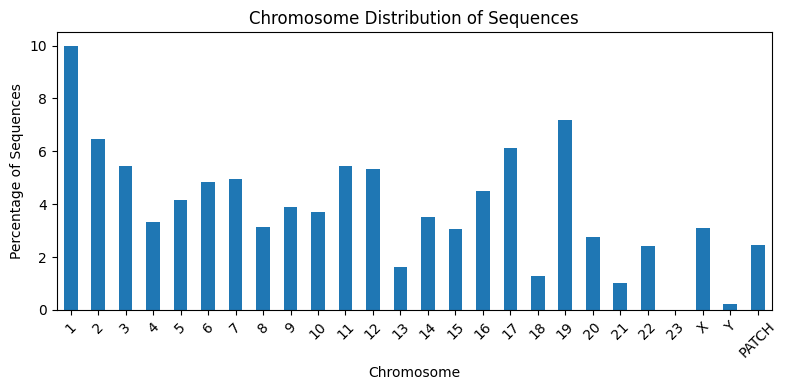

In [ ]:
#@title Data thresholding
import numpy as np

# Set threshold
log2FC_threshold = np.log2(0)

# Load input data
data_input = pd.read_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_Input.csv')

# Filter data based on threshold
filtered_data = data_input[
    (data_input['log2FC'] >= log2FC_threshold) |
    (data_input['log2FC'] <= -log2FC_threshold)
]

# Print summary
print(f"A total of {len(data_input)} sequences were filtered with |log2FC| > {log2FC_threshold} and {len(filtered_data)} were retained.")
print(f"log2FC > {log2FC_threshold}: {len(filtered_data[filtered_data['log2FC'] > log2FC_threshold])} sequences and log2FC < -{log2FC_threshold}: {len(filtered_data[filtered_data['log2FC'] < -log2FC_threshold])} sequences")

# Update the main dataframe if needed
data_input = filtered_data.reset_index(drop=True)

# Chromosome distribution
# Define ordered chromosome list
chr_order = [str(i) for i in range(1,24)] + ['X', 'Y', 'PATCH']

# Calculate distribution
chr_counts = data_combined['Chromosome'].value_counts()
total_seqs = len(data_combined)
chr_percentages = (chr_counts / total_seqs * 100).round(2)

# Reindex to ensure all chromosomes are included and ordered correctly
chr_percentages = chr_percentages.reindex(chr_order, fill_value=0)

# Display results
# print("Chromosome distribution of sequences:")
print("-" * 40)
for chr_num in chr_order:
    count = chr_counts.get(chr_num, 0)
    print(f"Chr {chr_num:>2}: {chr_percentages[chr_num]:>5.2f}% ({count} sequences)")

# Optional: Create bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=( 8, 4))
chr_percentages.plot(kind='bar')
plt.title('Chromosome Distribution of Sequences')
plt.xlabel('Chromosome')
plt.ylabel('Percentage of Sequences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ICE-T_ProDat/Chromosome_Distribution_all.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

filtered_data.to_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_filtered.csv', index=False)

Total filtered sequences loaded: 19124


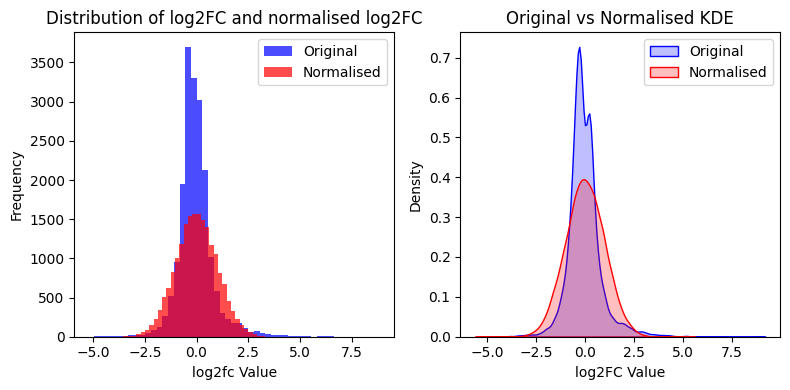

log2fc vs normalised log2fc:
  K-S Statistic: 0.14338004601547794
  P-value: 5.401586082356014e-172

Filtering...


<ipython-input-26-b455a717e552>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_below_1 = data_below_1.groupby('GeneID', group_keys=False).apply(filter_seq)


Updated data saved to ProSeq_Input_Norm.csv.

Total filtered sequences loaded: 12614


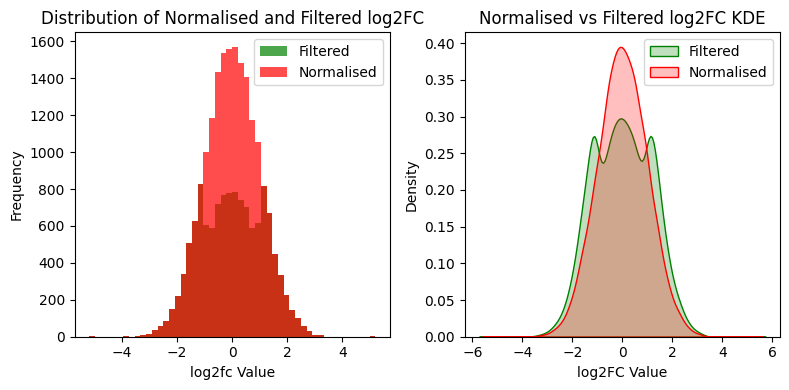

log2fc vs normalised log2fc:
  K-S Statistic: 0.08319824518110788
  P-value: 3.22085490676186e-46



In [26]:
#@title Distribution optimization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.preprocessing import QuantileTransformer

# Load the data
data_filtered = pd.read_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_Input.csv')
print(f"Total filtered sequences loaded: {len(data_filtered)}")

# 提取log2FC并进行Quantile变换并储存
log2fc = data_filtered['log2FC'].values
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
log2fc_norm = quantile_transformer.fit_transform(log2fc.reshape(-1, 1)).flatten()
data_filtered['log2FC_norm'] = log2fc_norm

# Visualize the distribution
plt.figure(figsize=(8, 4))

# Plot for log2fc
plt.subplot(1, 2, 1)
plt.hist(log2fc, bins=50, label='Original', color='blue', alpha=0.7)
plt.hist(log2fc_norm, bins=50, label='Normalised', color='red', alpha=0.7)
plt.title('Distribution of log2FC and normalised log2FC')
plt.xlabel('log2fc Value')
plt.ylabel('Frequency')
plt.legend()

# 绘制KDE图
plt.subplot(1, 2, 2)
sns.kdeplot(log2fc, fill=True, label='Original', color='blue')
sns.kdeplot(log2fc_norm, fill=True, label='Normalised', color='red')
plt.title(f'Original vs Normalised KDE')
plt.xlabel('log2FC Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ICE-T_ProDat/norm_log2fc_KDE.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

statistic, p_value = ks_2samp(log2fc, log2fc_norm)
print(f"log2fc vs normalised log2fc:")
print(f"  K-S Statistic: {statistic}")
print(f"  P-value: {p_value}\n")

print("Filtering...")

# 分离log2FC_norm绝对值大于等于1和小于1的两部分数据
data_above_or_equal_1 = data_filtered[abs(data_filtered['log2FC_norm']) >= 1]
data_below_1 = data_filtered[abs(data_filtered['log2FC_norm']) < 1]

# 针对log2FC_norm绝对值小于1的部分进行过滤
def filter_seq(group):
    if len(group) > 1:  # 如果有多个相同gene的记录
        return group[group['SeqID'].str.endswith('_F')]
    return group

filtered_below_1 = data_below_1.groupby('GeneID', group_keys=False).apply(filter_seq)

# 合并两部分数据
final_filtered_data = pd.concat([data_above_or_equal_1, filtered_below_1], ignore_index=True)

# 保存更新后的数据到新文件
final_filtered_data.to_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_Input_Norm.csv', index=False)
print("Updated data saved to ProSeq_Input_Norm.csv.")
# Load the new data
data_new = pd.read_csv('/content/drive/MyDrive/ICE-T_ProDat/ProSeq_Input_Norm.csv')
print(f"\nTotal filtered sequences loaded: {len(data_new)}")

log2fc_filtered = data_new['log2FC_norm'].values

# Visualize the distribution
plt.figure(figsize=(8, 4))

# Plot for log2fc
plt.subplot(1, 2, 1)
plt.hist(log2fc_filtered.flatten(), bins=50, label='Filtered', color='green', alpha=0.7)
plt.hist(log2fc_norm, bins=50, label='Normalised', color='red', alpha=0.7)
plt.title('Distribution of Normalised and Filtered log2FC')
plt.xlabel('log2fc Value')
plt.ylabel('Frequency')
plt.legend()

# 绘制KDE图
plt.subplot(1, 2, 2)
sns.kdeplot(log2fc_filtered.flatten(), fill=True, label='Filtered', color='green')
sns.kdeplot(log2fc_norm, fill=True, label='Normalised', color='red')
plt.title(f'Normalised vs Filtered log2FC KDE')
plt.xlabel('log2FC Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ICE-T_ProDat/filtered_log2fc_KDE.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

statistic, p_value = ks_2samp(log2fc_filtered, log2fc_norm)
print(f"log2fc vs normalised log2fc:")
print(f"  K-S Statistic: {statistic}")
print(f"  P-value: {p_value}\n")
